In [1]:
%load_ext autoreload
%autoreload 2

In this notebook we show how to train an unsupervised model using the [Barlow Twins](https://arxiv.org/pdf/2103.03230) architecture on the datasets generated in the previous notebook.

# Dataset

Check the [`dataset.ipynb`](./dataset.ipynb) notebook for more details. 

Here, we assume the dataset has been already downloaded with matches and located in a folder called `./data`. Change the path to the one you are using.

EOTDL implements some `Pytorch` and `Lightning` functionality for this use case.

In [16]:
from eotdl.pytorch.unsupervised import UnsupervisedDataModule

# dm = UnsupervisedDataModule('data/tifs/satellogic', batch_size=5)
dm = UnsupervisedDataModule('data/tifs/sentinel2', batch_size=5, bands=(4,3,2))
dm.setup()

Unsupervised
Number of images: 19


> For serius applications you may want to generate a much larger dataset !

Our dataset will give us pairs of the same image but with two different transformations.

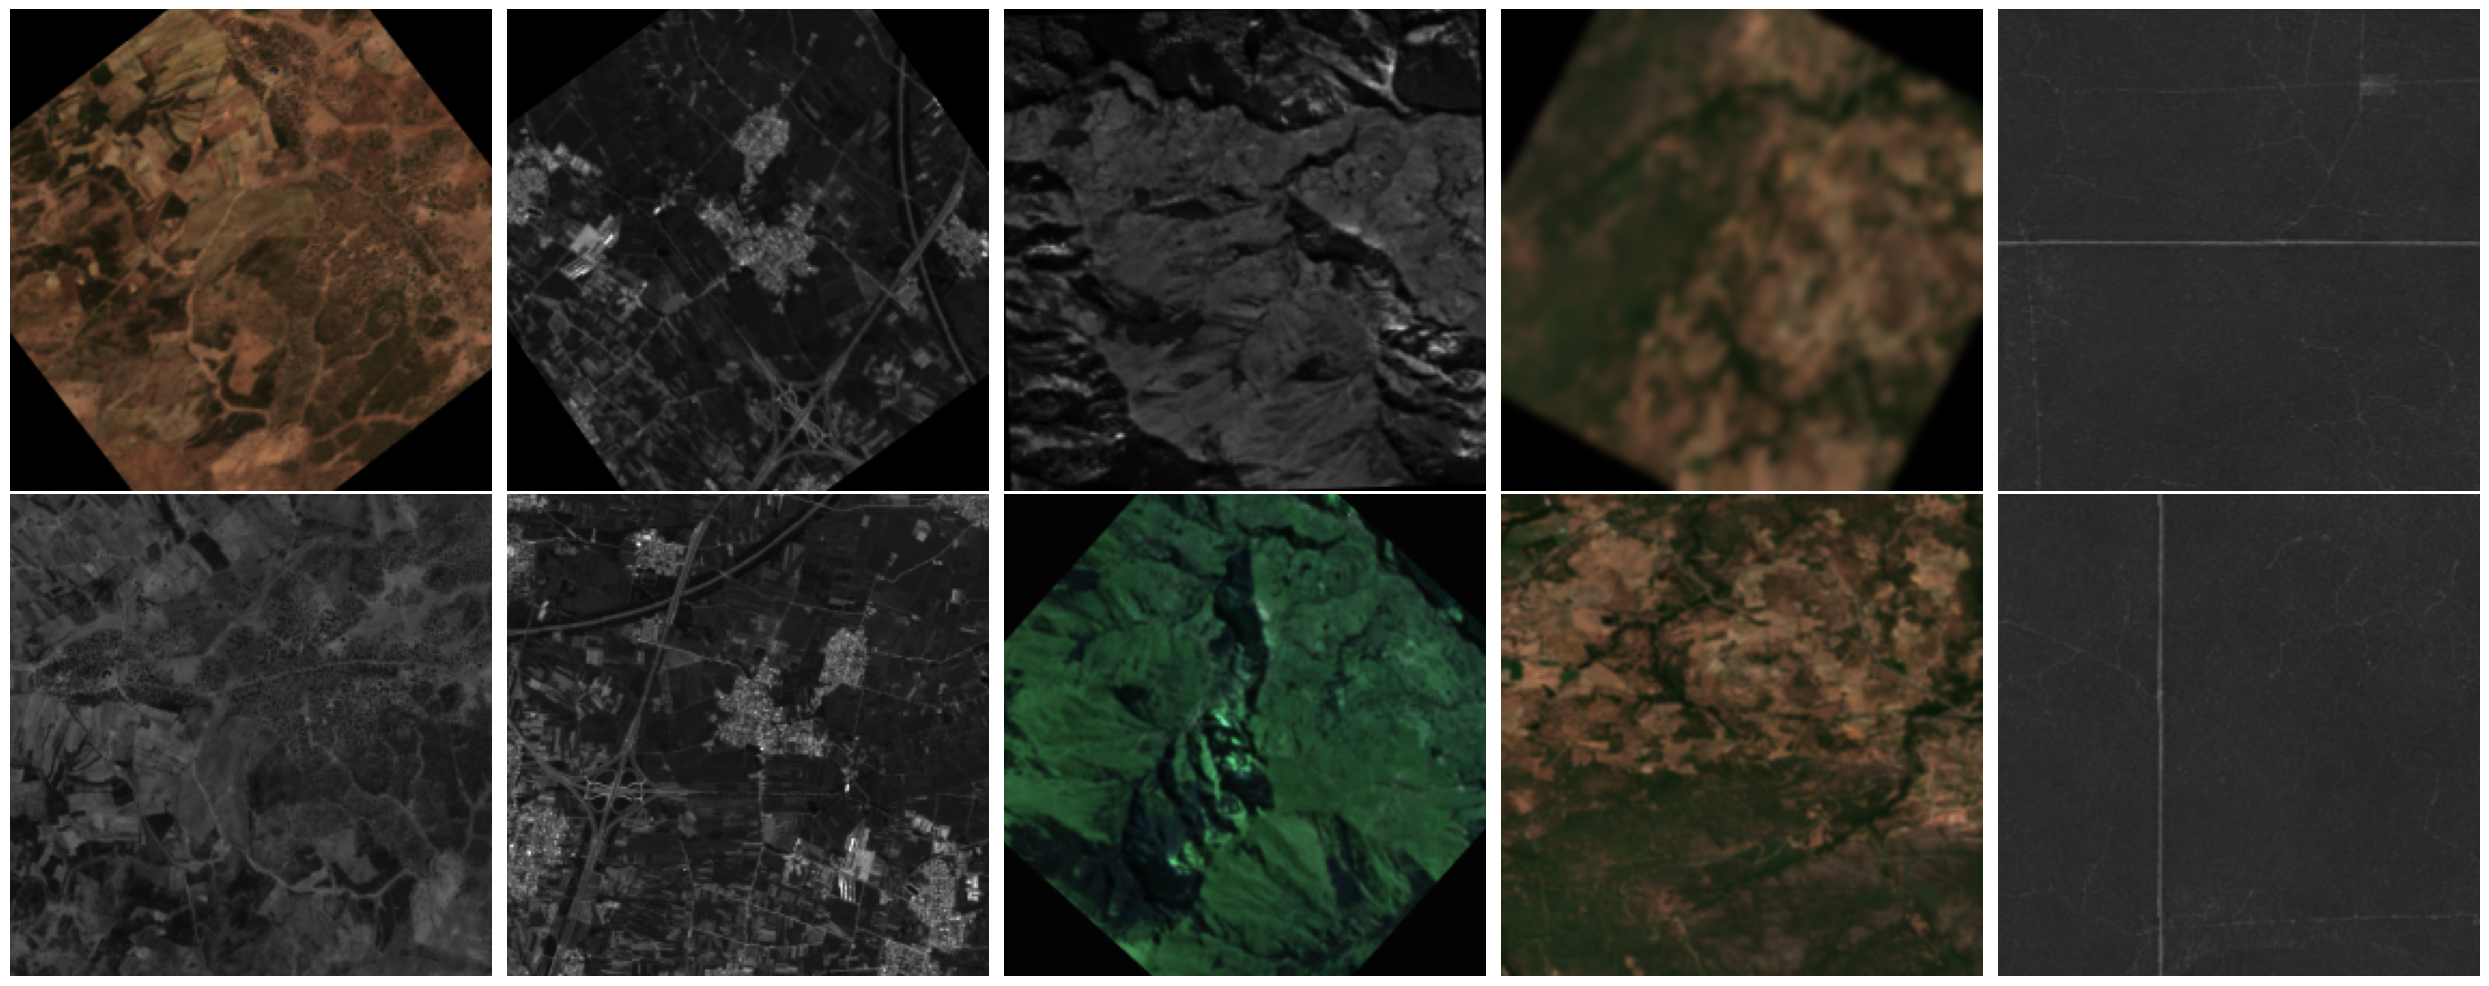

In [27]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader()))
images1, images2 = batch
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for i in range(5):
    img = images1[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    img = images2[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(img[..., :3])
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


For evaluating the model during and after training with Sentinel 2 images, we will use the [EuroSAT dataset](https://www.eotdl.com/datasets/EuroSAT).

In [28]:
from eotdl.pytorch.unsupervised import EuroSATDataModule

dm = EuroSATDataModule('data/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif', batch_size=25, bands=(4,3,2))
dm.setup()

EuroSAT
Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  21600
Validation samples:  5400


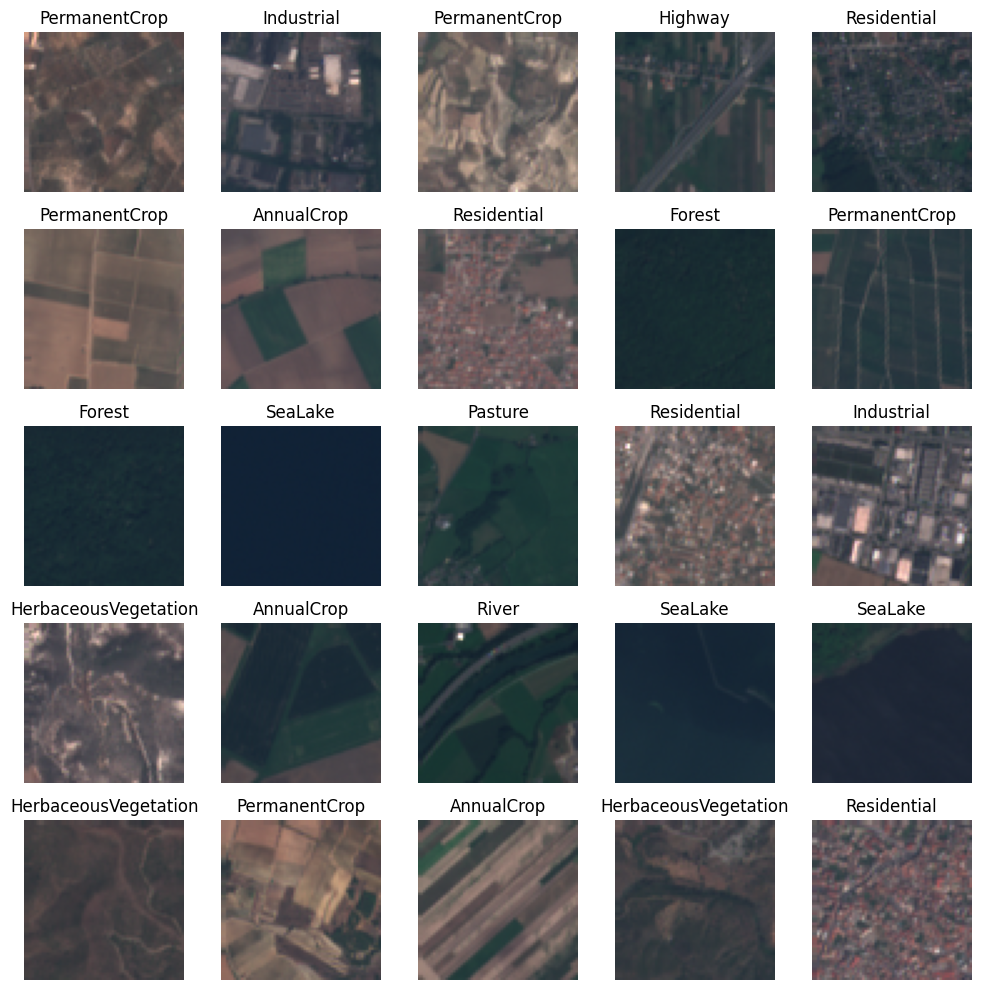

In [29]:
batch = next(iter(dm.train_dataloader()))
images, labels = batch
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(images):
            img = images[idx].permute(1, 2, 0).numpy()
            axes[i, j].imshow(img[..., :3])
            axes[i, j].set_title(f'{dm.labels[labels[idx]]}')
            axes[i, j].axis('off')
plt.tight_layout()
plt.show()

A similar process should be followed for the Sentinel 1 and Satellogic, although labeled Satellogic images are not very common.

# Model

EOTDL implements a basic unsupervised `Lighytning` module using `timm` models as backbone.

In [30]:
from eotdl.pytorch.unsupervised import UnsupervisedModule

config = {
    'backbone': 'resnet18',
    'mlp_dim': 2048,
    'in_chans': 3
}

module = UnsupervisedModule(config)

output = module(images1)
output.shape


torch.Size([5, 2048])

When pretraining with Sentinel 2 images, we will evaluate the model on the EuroSAT dataset.

In [31]:
from eotdl.pytorch.unsupervised import EuroSATModule

config = {
    'freeze': True,
    'num_classes': 10
}

module2 = EuroSATModule(config, module.backbone)

output = module2(images)
output.shape

torch.Size([25, 10])

# Training

We perform training with the `Lightning Trainer` class.

In [ ]:
import lightning as L

dm = UnsupervisedDataModule(
    'data/tifs/sentinel2',
    batch_size=4, 
    bands=(4,3,2)
)

module = UnsupervisedModule({
    'backbone': 'resnet18',
    'mlp_dim': 2048,
    'in_chans': 3
})

trainer =L.Trainer(
    max_epochs=5,
    accelerator='gpu',
    devices=1,
    # limit_train_batches=10,
    enable_checkpointing=False,
    logger=False,
)

trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | backbone | FeatureListNet | 11.2 M | train
1 | head     | Sequential     | 9.5 M  | train
----------------------------------------------------
20.6 M    Trainable params
0         Non-trainable params
20.6 M    Total params
82.512    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode


Unsupervised
Number of images: 19


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


When pretraining with Sentinel 2 images, we will evaluate the model on the EuroSAT dataset.

In [37]:
from eotdl.pytorch.unsupervised import SSLOnlineEvaluator

dm = UnsupervisedDataModule(
    'data/tifs/sentinel2',
    batch_size=4, 
    bands=(4,3,2)
)

module = UnsupervisedModule({
    'backbone': 'resnet18',
    'mlp_dim': 2048,
    'in_chans': 3
})

trainer =L.Trainer(
    max_epochs=3,
    accelerator='gpu',
    devices=1,
    # limit_train_batches=10,
    enable_checkpointing=False,
    logger=False,
    callbacks=[
        SSLOnlineEvaluator(
            '/fastdata/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif', 
            bands=(4,3,2), 
            label_ratio=0.01,
            head_epochs=10, 
            eval_period=1
        )
    ]
)

trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | backbone | FeatureListNet | 11.2 M | train
1 | head     | Sequential     | 9.5 M  | train
----------------------------------------------------
20.6 M    Trainable params
0         Non-trainable params
20.6 M    Total params
82.512    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode


Unsupervised
Number of images: 19
EuroSAT
Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  216
Validation samples:  5400


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


You can find a complete working example in the `train.py` script.